In [1]:
import MulensModel as mm
import matplotlib.pyplot as plt
import numpy as np
from param_utils import Param, Params

In [2]:
def get_curve(args):
    my_1S2L_model = mm.Model({'t_0': 2452848.06, 'u_0': args[0],
                              't_E': args[1], 'rho': args[2], 'q': args[3], 's': args[4],
                              'alpha': args[5]})
    lc = my_1S2L_model.get_lc(t_range=[2452810, 2452890], source_flux=1)
    return np.linspace(2452810, 2452890, len(lc)), lc

In [3]:
u_0 = Param("u_0", 0, np.sqrt(1), 0.5)
print(u_0)
print(u_0.get_sample_n(0, 1, 1))

(['u_0: 0.76'], [np.float64(0.7642544967278153)])


/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/model.py:267: UserWarning: No blend_flux not specified. Assuming blend_flux = zero.
  warnings.warn(
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)


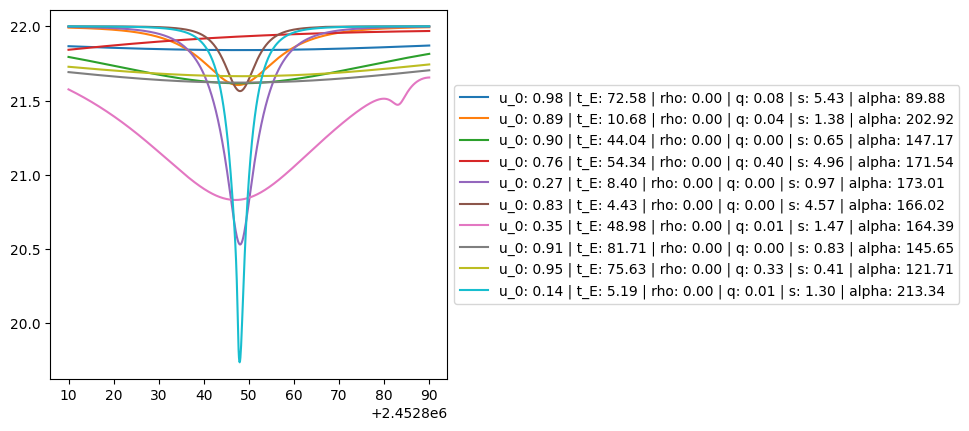

In [4]:
fig = plt.figure()
ax = plt.subplot(111)
for i in range(10):
    params = Params()
    args, labels = params.get_vals()
    x, y = get_curve(args)
    ax.plot(x, y, label=' | '.join(labels))
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
# add random light curve section to star as noise
from tqdm import tqdm
from astropy.io import ascii
import os
def choose_random_noise_curve(chunk_size=225, outlier_cutoff=2):
    
    fdir = "data/lightcurves/"
    directory = os.fsencode(fdir)
    files = os.listdir(directory)

    def grab_curve():
        selection_index = np.random.choice(len(files), replace=False) 

        curve = ascii.read(fdir + os.fsdecode(files[selection_index]), format='ipac')
        
        # check there are real values
        if np.count_nonzero(np.isreal(curve['cor_flux'])) == 0:
            return grab_curve()
        
        # grab first real value
        # TODO research masked column arrays to discover how to do this
        start = curve['cor_flux'].data.index(filter(lambda x: np.isreal(x), curve['cor_flux'].data)[0]) 
        
        x_filled = np.arange(curve['HJD'][start], curve['HJD'][start] + chunk_size)
        curve.remove_rows(np.where([c.data for c in curve.mask.itercols()])[-1])
        sample_interpolated = np.interp(x_filled, curve['HJD'], curve['cor_flux'])
        print(x_filled)
        print(sample_interpolated)
        return x_filled, sample_interpolated

    x_i, y_i = grab_curve()
    while max(abs(max(y_i)), abs(min(y_i))) > outlier_cutoff * np.std(y_i):
        print("outliers in our grab")
        x_i, y_i = grab_curve()

    return x_i, y_i

x, curve = choose_random_noise_curve()

fig = plt.figure()
plt.plot(x, curve)
plt.legend()
plt.show()

AttributeError: 'MaskedArray' object has no attribute 'index'